# Premier test de postérization de la couleur de l'image

Utilisation de la sgmentation pour donner un coté peinture à l'huile

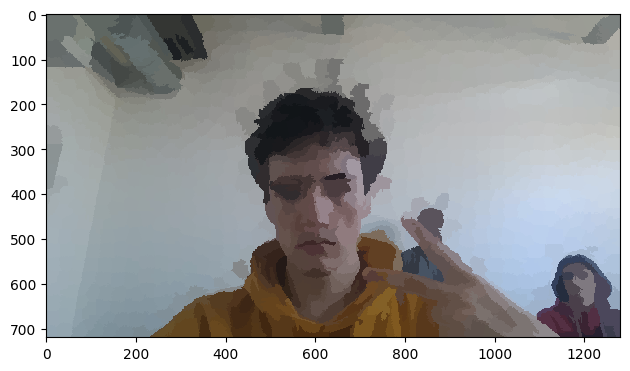

In [59]:
from skimage import data, segmentation, color
from skimage import graph
from skimage import io
from matplotlib import pyplot as plt
from skimage.util import img_as_float

img = img_as_float(io.imread("resources/images/test_1.jpg"))

labels1 = segmentation.slic(img, compactness=2, n_segments=1000, start_label=1)
img_posterized = color.label2rgb(labels1, img, kind='avg', bg_label=0)


io.imshow(img_posterized)

# Tweeks concernatn la coleur

In [60]:
from skimage import filters

img = img_as_float(io.imread("resources/images/test_1.jpg"))

filtered_img = filters.median(img, sigma=4)

labels1 = segmentation.slic(img, compactness=2, n_segments=1000, start_label=1)
posterized_image = color.label2rgb(labels1, filtered_img, kind='avg', bg_label=0)
filtered_posterized_image = filters.gaussian(posterized_image, sigma=4)


io.imshow(filtered_posterized_image)

TypeError: median() got an unexpected keyword argument 'sigma'

## Edge Detection (Sobel)

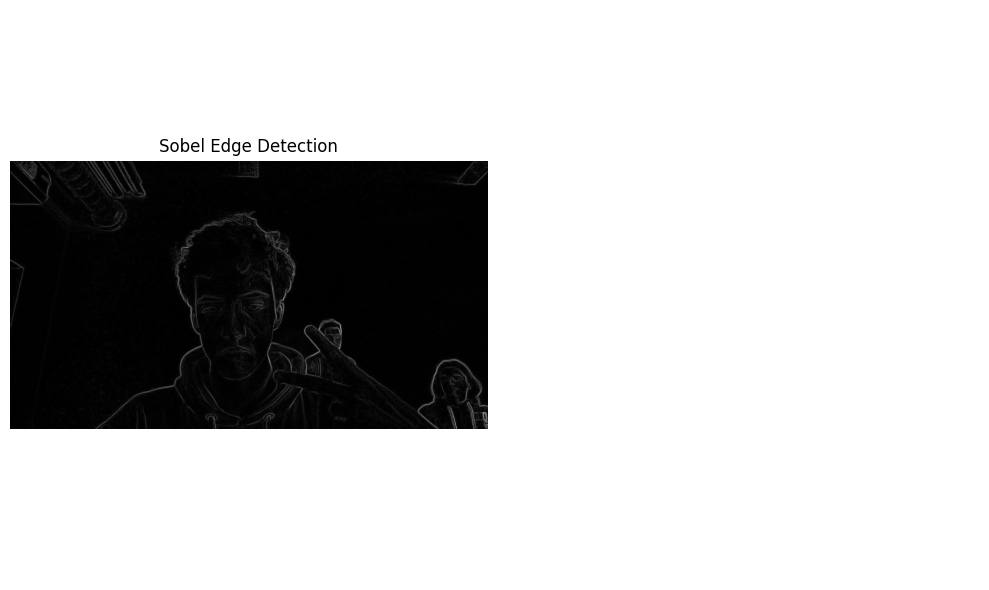

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from skimage.util import img_as_float
from skimage import io


image = img_as_float(io.imread("resources/images/test_1.jpg"))
#edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image[:,:,1])

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 6))

#axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
#axes[0].set_title('Roberts Edge Detection')

axes[0].imshow(edge_sobel, cmap=plt.cm.gray)
axes[0].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
axes[0].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Method Otsu

La méthode Otsu consiste à chercher le seuil optimal, c'est-à-dire celui qui minimise la variance intra-classe au sein des pixels blancs et des pixels noirs. Etant donné que notre objectif est de séparer le mieux possible les coutours blancs du reste noir elle est la meilleur solution.

Deplus, nous avons la contraite de la vidéo, il faut donc prendre en compte les changements de luminosité et de couleur. Le seuil d'Otsu est calculé à chaque fois pour être le meilleur seuil, nous n'avons donc plus besoin d'adapter le seuil à chaque frame à la main.

In [ ]:
from skimage import filters

Text(0.5, 1.0, 'Sobel Edge Detection + otsu')

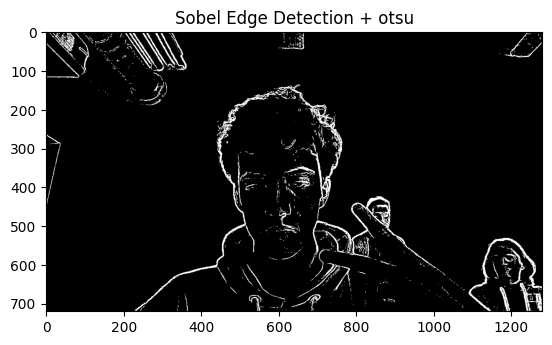

In [63]:
otsu_threshold = filters.threshold_otsu(edge_sobel)
image_binarized = edge_sobel > otsu_threshold

plt.imshow(image_binarized, cmap="gray")
plt.title("Sobel Edge Detection + otsu")